In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


In [3]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

In [4]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

In [5]:
enc_1 = Dense(200, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(200, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [7]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [8]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [9]:
VAE = Model(x, x_hat)

In [10]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [11]:
VAE.compile(loss=vae_loss, optimizer=Adam())
VAE.fit(x_train, x_train, batch_size=32, epochs=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 24s 403us/step - loss: 190.9365
Epoch 2/50
60000/60000 [==============================] - 24s 398us/step - loss: 180.0338
Epoch 3/50
60000/60000 [==============================] - 24s 394us/step - loss: 177.0818
Epoch 4/50
60000/60000 [==============================] - 24s 401us/step - loss: 171.9911
Epoch 5/50
60000/60000 [==============================] - 26s 430us/step - loss: 167.9937
Epoch 6/50
60000/60000 [==============================] - 26s 430us/step - loss: 165.5009
Epoch 7/50
60000/60000 [==============================] - 25s 418us/step - loss: 163.7124
Epoch 8/50
60000/60000 [==============================] - 25s 417us/step - loss: 162.1523
Epoch 9/50
60000/60000 [==============================] - 24s 406us/step - loss: 160.6680
Epoch 10/50
60000/60000 [==============================] - 25s 411us/step - loss: 159.2734
Epoch 11/50
60000/60000 [==========================

In [12]:
VAE_json = VAE.to_json()
open('VAE.json', 'w').write(VAE_json)
VAE.save_weights('VAE_weights.h5')

In [13]:
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          157000      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            402         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            402         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [14]:
h_input = Input(shape=(2,))
VAE_Encoder = Model(x, z_mean)
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

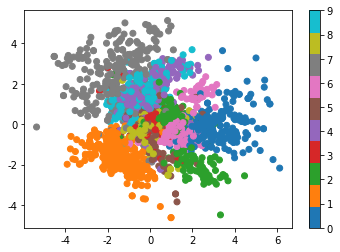

In [15]:
indices = np.random.randint(x_test.shape[0], size=3000)
latents = VAE_Encoder.predict(x_test[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap="tab10")
plt.colorbar()
plt.show()

In [16]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [17]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

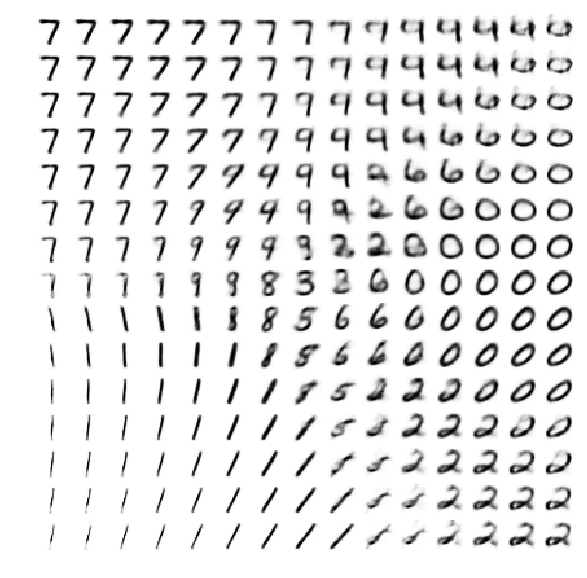

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

In [19]:
print('請輸入a, b 值(0~9)')
a = int(input("a = "))
b = int(input("b = "))
#idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)

for i in range(0, y_train0.size - 1):
    if y_train0[i] == a:
        idx_1 = i
        break
for i in range(0, y_train0.size - 1):
    if y_train0[i] == b:
        idx_2 = i
        break
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')


        
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

請輸入a, b 值(0~9)
a = 2
b = 6


interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>